In [ ]:
import glob
import os
import json
import torch
import pandas as pd

In [7]:
# get FedAvg and check it is learning
fed_avg = glob.glob(f"../results/periodic/**/FedAvg/**/federated_outputs", recursive=True)
fed_avg = glob.glob("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/work/b9/3b6d6b92f83daca0645b7d5820ebb1/federated_outputs", recursive=True)
fed_avg = fed_avg[0]
fed_avg

'/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/work/b9/3b6d6b92f83daca0645b7d5820ebb1/federated_outputs'

In [92]:
# per client load the weigths
cn = 0


In [93]:
def print_shapes(w):
    for i in range(len(w)):
        print(f"Layer {i}: {w[i].shape}")

# separate weigts and biases
def separate_weights(w):
    weights = []
    biases = []
    for i in range(len(w)):
        if(len(w[i].shape) == 2):
            weights.append(w[i])
        elif(len(w[i].shape) == 1):
            biases.append(w[i])
    return weights, biases

In [94]:
results = glob.glob(f"{fed_avg}/results_{cn}.json", recursive=True)[0]
with open(results, "r") as f:
    data = json.load(f)
# extract rounds and weights and put in a dataframe
rounds = []
weights = []
for i in range(len(data["client_train"])):
    rounds.append(data["client_train"][i]["round"])
    weights.append(data["client_train"][i]["weights"])
df_fedavg = pd.DataFrame({"round": rounds, "weights": weights})

def load_weigths(round):
    w_name = df_fedavg["weights"][round]
    w_file = glob.glob(f"{fed_avg}/../{w_name}", recursive=True)
    return torch.load(w_file[0])

def total_l2_norm(w0, w1):
    """Returns total L2 norm over all parameters."""
    diffs = [(torch.tensor(a) - torch.tensor(b)).flatten() for a, b in zip(w0, w1)]
    total_diff = torch.cat(diffs)
    return torch.norm(total_diff).item()

def l2norm_perlayer(w0, w1):
    """Returns L2 norm per layer."""
    diffs = [(torch.tensor(a) - torch.tensor(b)).flatten() for a, b in zip(w0, w1)]
    total_diff = torch.cat(diffs)
    return [torch.norm(diff).item() for diff in diffs]

# for each round, compute the l2 norm of the weights between current and previous
def compute_l2_norm(round):
    if round == 0:
        return 0
    else:
        return total_l2_norm(load_weigths(round-1), load_weigths(round))

# compute the l2 norm for each round
l2_norms = []
for i in range(len(df_fedavg)):
    l2_norms.append(compute_l2_norm(i))
# add the l2 norm to the dataframe
df_fedavg["l2_norm"] = l2_norms

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_62320/2654216139.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(w_file[0])


In [95]:
# Assuming df_fedavg is already defined
l2_norms_weights = []
l2_norms_biases = []

for i in range(len(df_fedavg)):
    w = load_weigths(i)  # Should return a list of tensors or arrays
    weights, biases = separate_weights(w)  # Should return two lists

    # Convert to tensors if not already
    weights = [torch.tensor(w) for w in weights]
    biases = [torch.tensor(b) for b in biases]

    # Flatten and concatenate
    if weights:
        l2_w = torch.norm(torch.cat([w.flatten() for w in weights])).item()
    else:
        l2_w = 0.0

    if biases:
        l2_b = torch.norm(torch.cat([b.flatten() for b in biases])).item()
    else:
        l2_b = 0.0

    l2_norms_weights.append(l2_w)
    l2_norms_biases.append(l2_b)

# Add to dataframe
df_fedavg["l2_norm_weights"] = l2_norms_weights
df_fedavg["l2_norm_biases"] = l2_norms_biases
# save the dataframe to a csv fil

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_62320/2654216139.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(w_file[0])


In [96]:
df_fedavg

,round,weights,l2_norm,l2_norm_weights,l2_norm_biases
0,0,weights_896415.pt,0.000000,61.511555,8.138094
1,1,weights_314179.pt,67.221474,81.074944,10.151161
2,2,weights_854482.pt,65.537552,91.058868,13.303809
3,3,weights_12765.pt,55.793865,93.459831,13.202818
4,4,weights_903380.pt,60.226425,104.090004,13.947058


In [97]:

# Assuming df_fedavg is already defined
l2_norms_weights_per_layer = []
l2_norms_biases_per_layer = []

for i in range(len(df_fedavg)):
    w = load_weigths(i)  # list of tensors or arrays
    weights, biases = separate_weights(w)  # returns two lists

    weights = [torch.tensor(w) for w in weights]
    biases = [torch.tensor(b) for b in biases]

    l2_weights = [torch.norm(w.flatten()).item() for w in weights]
    l2_biases = [torch.norm(b.flatten()).item() for b in biases]

    l2_norms_weights_per_layer.append(l2_weights)
    l2_norms_biases_per_layer.append(l2_biases)

# Add lists to dataframe
df_fedavg["l2_weights_per_layer"] = l2_norms_weights_per_layer
df_fedavg["l2_biases_per_layer"] = l2_norms_biases_per_layer

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_62320/2654216139.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(w_file[0])


In [98]:
df_fedavg

,round,weights,l2_norm,l2_norm_weights,l2_norm_biases,l2_weights_per_layer,l2_biases_per_layer
0,0,weights_896415.pt,0.000000,61.511555,8.138094,"[17.15289878845215, 11.609171867370605, 18.023...","[2.314305067062378, 1.2984036207199097, 2.5891..."
1,1,weights_314179.pt,67.221474,81.074944,10.151161,"[23.77332878112793, 16.564165115356445, 24.884...","[1.8402799367904663, 1.2196860313415527, 2.986..."
2,2,weights_854482.pt,65.537552,91.058868,13.303809,"[27.72836685180664, 17.60900115966797, 24.7459...","[3.4933364391326904, 1.5892060995101929, 3.621..."
3,3,weights_12765.pt,55.793865,93.459831,13.202818,"[27.880380630493164, 17.454187393188477, 25.59...","[2.239858627319336, 1.6645770072937012, 4.0708..."
4,4,weights_903380.pt,60.226425,104.090004,13.947058,"[29.904338836669922, 19.721227645874023, 29.30...","[2.8728959560394287, 2.065176486968994, 4.6950..."


In [109]:
# Step 1: Explode and add layer_id
df_weights = df_fedavg[["round", "l2_weights_per_layer"]].explode("l2_weights_per_layer")
df_weights["layer_id"] = df_weights.groupby("round").cumcount()
df_weights["round"] = df_weights["round"] + 1

# Step 2: Get all layer sizes per round
layer_sizes_all_rounds = []
for i in range(len(df_fedavg)):  # one per round
    w = load_weigths(i)
    weights, _ = separate_weights(w)
    layer_sizes_all_rounds.extend([w.shape for w in weights])  # flat list

# Step 3: Add to exploded dataframe
df_weights["layer_size"] = layer_sizes_all_rounds

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_62320/2654216139.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(w_file[0])


In [111]:
df_weights

,round,l2_weights_per_layer,layer_id,layer_size
0,1,17.152899,0,"(100, 42)"
0,1,11.609172,1,"(20, 100)"
0,1,18.023975,2,"(100, 42)"
0,1,11.897471,3,"(20, 100)"
0,1,18.638783,4,"(100, 42)"
...,...,...,...,...
4,5,15.545424,10,"(20, 100)"
4,5,14.923512,11,"(100, 10)"
4,5,45.556538,12,"(100, 100)"
4,5,14.16213,13,"(10, 100)"


<Figure size 600x400 with 0 Axes>

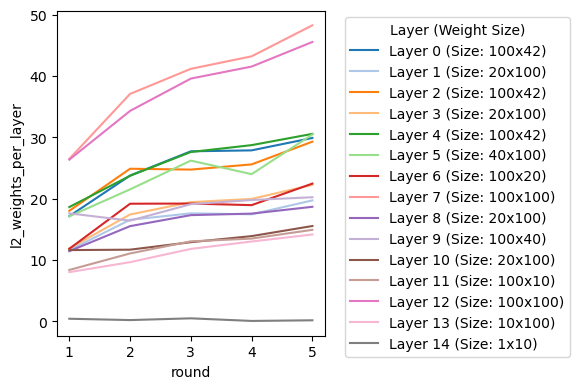

In [112]:
# plot l2_weitghs per layer vs round
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))



plt.figure(figsize=(6, 4))

num_layers = df_weights["layer_id"].nunique()
palette = sns.color_palette("tab20", num_layers)

ax = sns.lineplot(
    data=df_weights,
    x="round",
    y="l2_weights_per_layer",
    hue="layer_id",
    palette=palette
)

# Build custom legend labels with layer sizes
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
    layer_id = int(label)
    # Get the first layer_size value for this layer_id (assuming consistent shape)
    size = df_weights[df_weights["layer_id"] == layer_id]["layer_size"].iloc[0]
    # Format the size tuple nicely
    size_str = "x".join(map(str, size)) if isinstance(size, (tuple, list)) else str(size)
    new_labels.append(f"Layer {layer_id} (Size: {size_str})")

# Update legend with new labels
ax.legend(handles=handles, labels=new_labels, title="Layer (Weight Size)", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()





/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_62320/2654216139.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(w_file[0])


In [103]:
df_fedavg

,round,weights,l2_norm,l2_norm_weights,l2_norm_biases,l2_weights_per_layer,l2_biases_per_layer,layer_sizes
0,0,weights_896415.pt,0.000000,61.511555,8.138094,"[17.15289878845215, 11.609171867370605, 18.023...","[2.314305067062378, 1.2984036207199097, 2.5891...","[(100, 42), (20, 100), (100, 42), (20, 100), (..."
1,1,weights_314179.pt,67.221474,81.074944,10.151161,"[23.77332878112793, 16.564165115356445, 24.884...","[1.8402799367904663, 1.2196860313415527, 2.986...","[(100, 42), (20, 100), (100, 42), (20, 100), (..."
2,2,weights_854482.pt,65.537552,91.058868,13.303809,"[27.72836685180664, 17.60900115966797, 24.7459...","[3.4933364391326904, 1.5892060995101929, 3.621...","[(100, 42), (20, 100), (100, 42), (20, 100), (..."
3,3,weights_12765.pt,55.793865,93.459831,13.202818,"[27.880380630493164, 17.454187393188477, 25.59...","[2.239858627319336, 1.6645770072937012, 4.0708...","[(100, 42), (20, 100), (100, 42), (20, 100), (..."
4,4,weights_903380.pt,60.226425,104.090004,13.947058,"[29.904338836669922, 19.721227645874023, 29.30...","[2.8728959560394287, 2.065176486968994, 4.6950...","[(100, 42), (20, 100), (100, 42), (20, 100), (..."
